# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.09500000160187483


When finished, you can close the environment.

In [5]:
#env.close()

### 4. Train your agent

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

###### 4.1 Learning algorithm -  DDPG

Deep Deterministic Policy Gradient was proposed in Continuous control with deep reinforcement learning(Lillicrap et al, 2015). DDPG is an off policy algorithm and can only be used only for continuous action spaces. It simultaneously learns a function and a policy. It's an actor critic algorithm and uses two neural networks. The algorithm also applies experience replay and target networks to stabilize the training. To boost exploration, the authors of the DDPG paper have used Ornstein-Uhlenbeck Process to add noise to the action output. But for this training run, I would only be adding Gaussian noise.

<figure>
    <img src="images/algorithm.png" width="600" height="400">
    <figcaption style = "text-align:center; font-style:italic">Taken from Continuous control with deep reinforcement learning(Lillicrap et al, 2015)</figcaption>
</figure>
    
###### 4.1 Model architecture

The Actor network consist of three fully connected layer with batchnormalization applied at the first layer. The network maps states to actions. It uses ReLU as activation function except the last layer where it use tanh. 

The critic network also consist of three fully connected layer with batchnormalization applied at the first layer. The network maps maps (state,action) pairs to Q-values. It uses ReLU as activation function in the first two layers and no activation function for the last layer.

###### 4.1 Hyperparameters

* fc1_units=400 # Number of nodes in the first hidden layer
* fc2_units=300 # Number of nodes in the second hidden layer
* BUFFER_SIZE = int(1e6) # replay buffer size
* BATCH_SIZE = 256       # minibatch size
* GAMMA = 0.99           # discount factor
* TAU = 2e-3             # for soft update of target parameters
* LR_ACTOR = 1e-3        # learning rate of the actor
* LR_CRITIC = 1e-3       # learning rate of the critic
* WEIGHT_DECAY = 0       # L2 weight decay
* LEARN_EVERY = 1       # learning timestep interval
* LEARN_NUM = 10            # number of learning passes
* GRAD_CLIPPING = 1.0         # gradient clipping 
* EPSILON = 1.0         # for epsilon in the noise process (act step)
* EPSILON_DECAY = 1e-6 # epsilon decay rate

In [6]:
import numpy as np
import random
import time
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from ddpg_agent import Agent
from unityagents import UnityEnvironment

In [7]:
seed = 3

In [8]:
# DDPG function
def ddpg(num_episodes=10000, max_t=1000, print_every=10, actor_weights_name='actor.pth', critic_weights_name='critic.pth'):
    """Deep Deterministic Policy Gradient
    
    Params
    ======
    n_episodes (int): maximum number of training episodes
    max_t (int): maximum number of timesteps per episode
    print_every (int): interval to display results
    
    """
    max_scores = [] # list of mean scores from each episode
    moving_avgs = [] # list of moving averages
    best_score = -np.inf
    scores_window = deque(maxlen=100) # mean score from last 100 episodes
    initial_time = time.time()
    
    for i_episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations # get current state for each observations
        scores = np.zeros(num_agents) # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True) # select an action
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations # get next state (for each agent)
            rewards = env_info.rewards # get reward (for each agent)
            dones = env_info.local_done # see if episode finished
            # perform learning step
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        duration = time.time() - start_time
        max_scores.append(np.max(scores)) # save max score for each episode
        scores_window.append(max_scores[-1]) # save max score to window
        moving_avgs.append(np.mean(scores_window)) # save moving average
        
        if i_episode % print_every == 0:
            print("\rEpisode {} ({}s)\tMax score: {:.3f}\tMoving Avg: {:.3f}"\
                  .format(i_episode, round(duration), max_scores[-1], moving_avgs[-1]))
        if moving_avgs[-1] >= 0.5:
            print("\nEnvironment solved in {:d} episodes.\tAverage score: {:.3f}\tTotal training time: {}s"\
                 .format(i_episode, moving_avgs[-1], (time.time()-initial_time)))
            torch.save(agent.actor_local.state_dict(), actor_weights_name)
            torch.save(agent.critic_local.state_dict(), critic_weights_name)
            break
            
    return max_scores, moving_avgs
    

In [9]:
# start the training loop
agent = Agent(state_size=state_size, action_size=action_size, random_seed=seed)

In [10]:
scores, avgs = ddpg(actor_weights_name ='actor_tennis.pth', critic_weights_name='critic_tennis.pth')

Episode 10 (2s)	Max score: 0.000	Moving Avg: 0.000
Episode 20 (2s)	Max score: 0.000	Moving Avg: 0.005
Episode 30 (2s)	Max score: 0.000	Moving Avg: 0.003
Episode 40 (2s)	Max score: 0.000	Moving Avg: 0.003
Episode 50 (5s)	Max score: 0.090	Moving Avg: 0.009
Episode 60 (5s)	Max score: 0.090	Moving Avg: 0.016
Episode 70 (9s)	Max score: 0.100	Moving Avg: 0.028
Episode 80 (4s)	Max score: 0.100	Moving Avg: 0.033
Episode 90 (5s)	Max score: 0.100	Moving Avg: 0.038
Episode 100 (5s)	Max score: 0.100	Moving Avg: 0.040
Episode 110 (10s)	Max score: 0.190	Moving Avg: 0.051
Episode 120 (5s)	Max score: 0.090	Moving Avg: 0.057
Episode 130 (2s)	Max score: 0.000	Moving Avg: 0.061
Episode 140 (2s)	Max score: 0.000	Moving Avg: 0.062
Episode 150 (10s)	Max score: 0.190	Moving Avg: 0.062
Episode 160 (8s)	Max score: 0.100	Moving Avg: 0.069
Episode 170 (10s)	Max score: 0.200	Moving Avg: 0.080
Episode 180 (5s)	Max score: 0.090	Moving Avg: 0.087
Episode 190 (17s)	Max score: 0.300	Moving Avg: 0.090
Episode 200 (5s)	

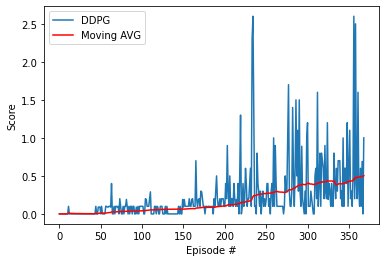

In [11]:
# plot scores across episodes
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


In [12]:
env.close()

<Figure size 432x288 with 0 Axes>

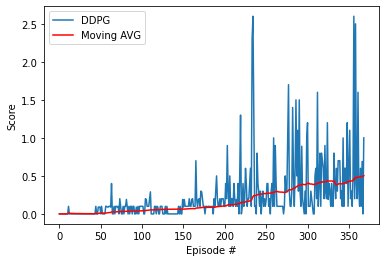

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='DDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.savefig('score.png')
plt.show()

### 5. Future ideas to improve the agent's performance

* DDPG can be improved by using prioritized experience replay. 
* Fine-tuning of hperparameters can also lead to better results and faster training time.
* Applying [Multi Agent Actor Critic for Mixed Cooperative Competitive environments](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf)